A first DMFT calculation
========================

The goal of this notebook is to make a first DMFT calculation using the iterated perturbation theory (IPT) to solve the impurity problem.
You will proceed in two steps: first you will set up the IPT
impurity solver and then you will set up the DMFT loop.

The iterated perturbation theory
--------------------------------

The IPT is a cheap way to solve the impurity problem which is restricted
to half-filling. It approximates the self-energy by second-order
perturbation theory, just like in the last exercise of the notebook
on Green's functions:

$$ \Sigma(i\omega_n) = \frac{U}{2} + U^2 \int_0^\beta d\tau e^{i \omega_n \tau} {\cal G}_0(\tau)^3 $$

Note that the first term, $\frac{U}{2}$, is the chemical potential $\mu$ for half-filling.


In [1]:
from triqs.gf import *
from triqs.plot.mpl_interface import oplot,plt
from math import pi
import numpy as np


### Exercise 1

An impurity solver takes a non-interacting Green's function $G_0$, an impurity interaction $U$ and an inverse temperature $\beta$ as an input and returns the interacting Green's function $G$ as well as the
self-energy $\Sigma$.

Write a function that takes $U$, $\beta$ and ${\cal G}_0(i\omega)$ as an input and returns the second order perturbation theory result for $\Sigma(i\omega)$ as well as the corresponding $G(i\omega)$. 
If you are more familiar with python, you can write a `Solver` class that is constructed with $\beta$.
The class should contain a class member `G0` that is to be initialized by the user.
It should further contain a member function `solve` that, given the interaction $U$, sets the class members $G$ and $\Sigma$ to the results. 
The advantage of using a class is that Green's functions will not have to be constructed at every call of the
function `solve`.

The IPT only works at half-filling, which corresponds to $\mu=U/2$. It is however common practice to shift both the self-energy and $\mu$ by $-U/2$ (keeping $G$ unchanged). This way $\mu=0$ corresponds to the half-filled case, and the self-energy only consists of the second term in the IPT equation.

In [2]:
# VERSION 1
# Function solve
def solve(U, G0, beta):

    Sigmat = GfImTime(indices=[0], beta=beta)
    Sigmat << Fourier(G0)
    Sigmat << U**2*Sigmat*Sigmat*Sigmat

    Sigma = GfImFreq(indices=[0], beta=beta, name='$\Sigma$')
    Sigma << Fourier(Sigmat)

    G = GfImFreq(indices=[0], beta=beta, name='G')
    G << inverse(inverse(G0)-Sigma)

    return G, Sigma

# VERSION 2
# Class version
class IPTSolver:
    def __init__(self, beta):

        self.g0 = GfImFreq(indices=[0], beta=beta, name='$G_0$')
        self.g0t = GfImTime(indices=[0], beta=beta, name='$\Sigma_\tau$')
        self.sigmat = GfImTime(indices=[0], beta=beta, name='$\Sigma_\tau$')
        self.sigma = GfImFreq(indices=[0], beta=beta, name='$\Sigma$')
        self.g = GfImFreq(indices=[0], beta=beta, name='G')

    def solve(self,U):

        self.g0t << Fourier(self.g0)
        self.sigmat << U**2*self.g0t*self.g0t*self.g0t

        self.sigma << Fourier(self.sigmat)

        self.g << inverse(inverse(self.g0)-self.sigma)

Dynamical mean-field theory
----------------------------

In DMFT, the lattice self-energy is approximated by that of an impurity
model. One has to recursively solve a model in order to satisfy the
self-consistency relation

$$ G_\mathrm{imp} = \sum_k \frac{1}{i \omega_n + \mu - \epsilon_k - \Sigma_\mathrm{imp}} $$

In practice one starts with a chosen ${\cal G}_0$ and then solves the quantum
impurity problem. This yields $\Sigma_\mathrm{imp}$. Using the self-consistency
relation and Dyson's equation, we have a new proposal for ${\cal G}_0$:

$$ \Big( {\cal G}_0^\mathrm{new} \Big)^{-1} =
\Big( \sum_k \frac{1}{i \omega_n + \mu - \epsilon_k - \Sigma_\mathrm{imp}} \Big)^{-1}
+ \Sigma_\mathrm{imp} $$

We solve the quantum impurity for this new $G_0$ and loop until
convergence

<img src="files/selfcons.png" width=40%>


Bethe lattice DMFT
------------------

When the lattice is a Bethe lattice with infinite coordination, the self-consistency relation
discussed above takes a particularly simple form

$$ {\cal G}_0^{-1} = i\omega_n + \mu - t^2 G_\mathrm{imp} $$

### Exercise 2

You will now implement the DMFT loop for the Bethe lattice using the IPT solver that you have
defined above. We give you the beginning of the script so that you have the parameters.
In order to see how the DMFT loops converge, plot the spectral function of the Green's function
at every loop. Use the Pade approximation to obtain the real-frequency Green's function.

Note that, as we chose the convention $\mu=0$ for the IPT solver, the chemical potential also drops out of the self-consistency relation of the Bethe lattice.

Remember that the non-interacting Green's function ${\cal G}_0(i\omega)$ for the Bethe lattice can be obtained using `SemiCircular`.

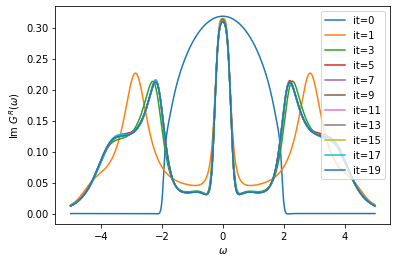

In [3]:
# Parameters of the model
t = 1.0
U = 5.0
beta = 20

# Number of DMFT loops
n_loops = 20

# DMFT loop with self-consistency
g0 = GfImFreq(indices=[0], beta=beta)
g0 << SemiCircular(2*t)
gr = GfReFreq(indices=[0], window=(-5,5),name='$G^R$')

ipt = IPTSolver(beta)
ipt.g0 << g0

gr.set_from_pade(ipt.g0)
oplot(-gr.imag/pi,label=f"it=0")

m = 2

for k in range(n_loops):
    ipt.solve(U)
    ipt.g0 << inverse(iOmega_n-t**2*ipt.g)
    if k%m==m-1:
        gr.set_from_pade(ipt.g)
        oplot(-gr.imag/pi,label=f"it={k}")
plt.show()

Visualizing the Mott transition
-------------------------------

You now have all the material to do a scan for different values of $U$ and see how a Mott transition appears.

### Exercise 3

Write a script which scans values of $U$ between 2.0 and 8.0 and plot the spectral function.
Where does the Mott transition appear?

-------------------------- U=2.0 --------------------------


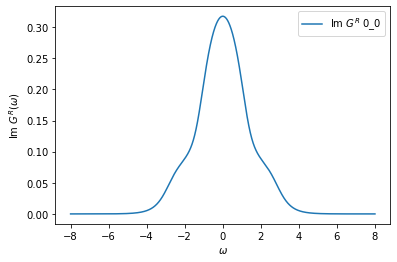

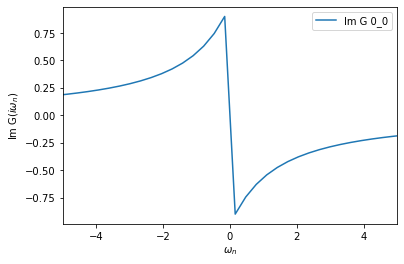

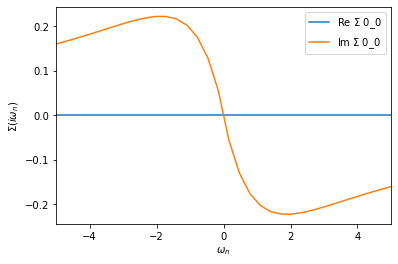

-------------------------- U=3.0 --------------------------


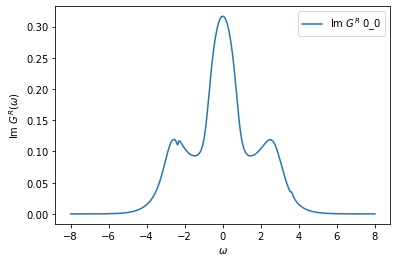

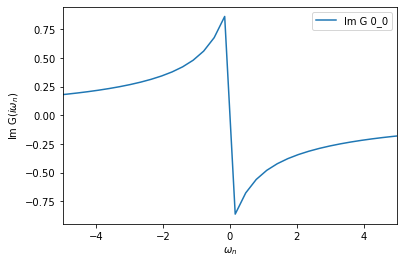

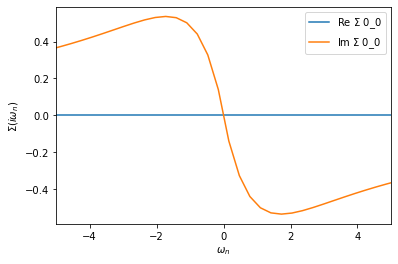

-------------------------- U=4.0 --------------------------


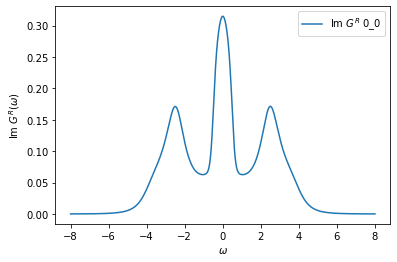

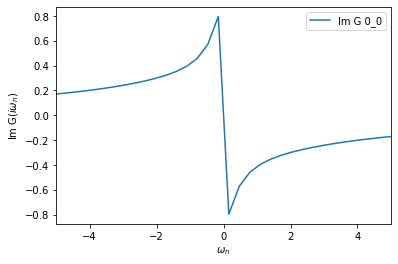

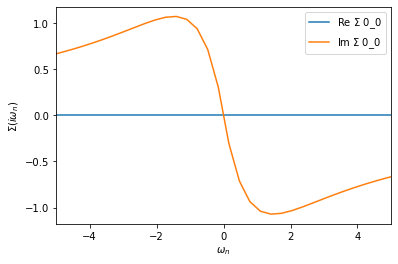

-------------------------- U=5.0 --------------------------


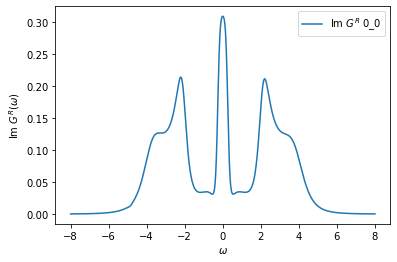

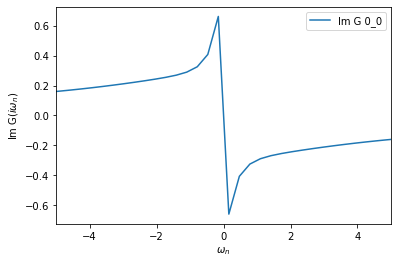

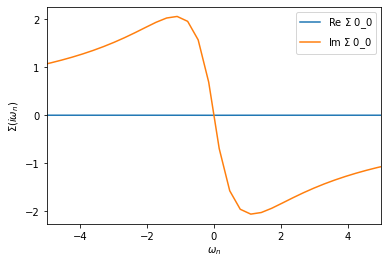

-------------------------- U=6.0 --------------------------


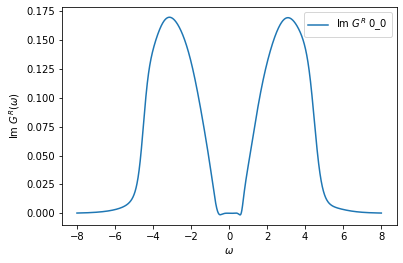

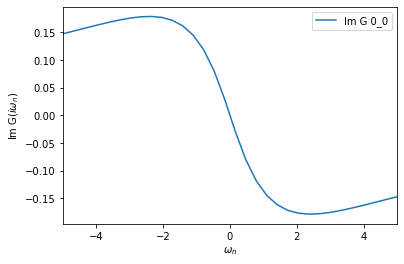

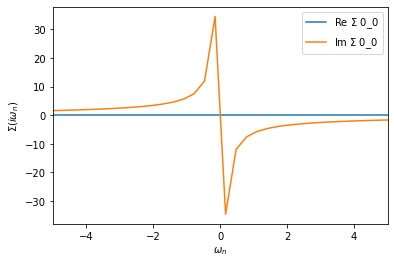

-------------------------- U=7.0 --------------------------


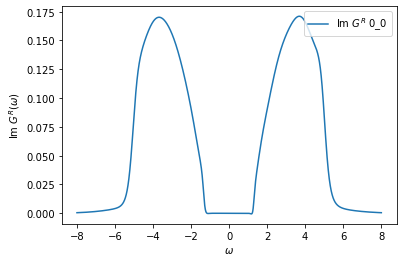

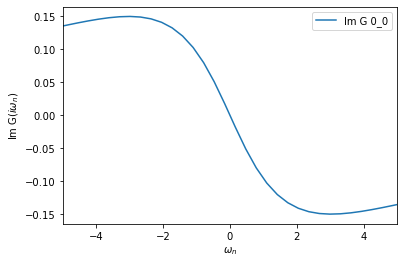

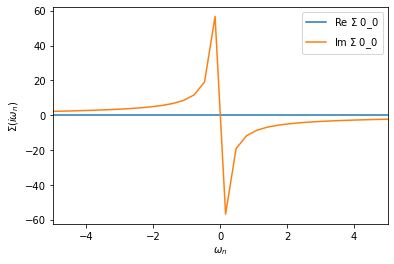

In [7]:
import numpy as np

# Parameters of the model
t = 1.0
beta = 20
n_loops = 25

g0 = GfImFreq(indices=[0], beta=beta)
g0 << SemiCircular(2*t)
gr = GfReFreq(indices=[0], window=(-8,8),name='$G^R$')

ipt = IPTSolver(beta)

# Loop over values of U
for U in np.arange(2.0, 8.0, 1.0):
    ipt.g0 << g0
    for k in range(n_loops):
        ipt.solve(U)
        ipt.g0 << inverse(iOmega_n-t**2*ipt.g)
    gr.set_from_pade(ipt.g)
    print(f'-------------------------- U={U} --------------------------')
    oplot(-gr.imag/pi)
    plt.show()
    oplot(ipt.g.imag)
    plt.xlim(-5,5)
    plt.show()
    oplot(ipt.sigma)
    plt.xlim(-5,5)
    plt.show()